##* Design MLP with 2 hidden layers (Input Layer - 2 hidden Layer - Output layer) to classify objects digits (MNIST).
##* Design Coustomized optimizer and compare with inbuilt optimizer adam.

#* tfv5097@psu.edu :Thejasvi Velaga

In [1]:
# baseline cnn model for mnist
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
seed=5097
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.list_physical_devices('GPU')

[]

In [2]:
# Constants 
size_input = 784
size_hidden = [128,128,128]
size_output = 10
number_of_train_examples = 60000 #60000
number_of_test_examples = 10000   #10000

## Load Dataset Function

In [3]:
#To load the data set for mist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
#create validation set
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

In [5]:
X_train = X_train.reshape(X_train.shape[0],-1)#.T
X_test = X_test.reshape(X_test.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

In [6]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
# normalize to range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val/255

In [7]:
# one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)


##**The below 2 blocks codes is with L1 reguralization and with custom optimization repesctively.**




In [8]:
#with L2  regularization.
class MLP(tf.keras.Model):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    super(MLP, self).__init__()
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """

    # self.size_input = 784
    # self.size_hidden = 128
    # self.size_output = 10
    # self.device = 'gpu'
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer and hideen layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

    # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_hidden[2]]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden[2]]))

    # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden[2], self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.MLP_variables = [self.W1, self.W2,self.W3,self.W4, self.b1, self.b2, self.b3,self.b4]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf,labels=y_true_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    optimizer = tf.keras.optimizers.Adam()
    #optimizer = tf.keras.optimizers.Adamax(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)+0.01*tf.nn.l2_loss(self.W2) +0.001*tf.nn.l2_loss(self.W3)+0.1*tf.nn.l2_loss(self.W4)
      #v = tf.concat([tf.reshape(v,[-1]) for v in self.variables[:3]],0)
      #current_loss  += 1e-2 * tf.nn.l2_loss(v)
    grads = tape.gradient(current_loss, self.MLP_variables)
    optimizer.apply_gradients(zip(grads, self.MLP_variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)


    what1 = tf.matmul(hhat, self.W2) + self.b2
    hhat1 = tf.nn.relu(what1)

    what2 = tf.matmul(hhat1, self.W3) + self.b3
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    #output=tf.nn.softmax(output)
    return output

In [9]:
class MLP_cust(tf.keras.Model):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    super(MLP_cust, self).__init__()
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer and hideen layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

    # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_hidden[2]]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden[2]]))

    # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden[2], self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.MLP_variables = [self.W1, self.W2,self.W3,self.W4, self.b1, self.b2, self.b3,self.b4]

    #m,v,u,L,m_corrected,v_corrected,u_corrected=self.initialize_adam()
    self.m,self.v,self.u,self.L,self.m_corrected,self.v_corrected,self.u_corrected=[],[],[],4,[],[],[]
    
    self.t,self.learning_rate,self.beta1, self.beta2, self.beta3,self.epsilon=\
    t,learning_rate,beta1, beta2,beta3,epsilon = 0,0.005,0.9,0.999,0.999999,1e-8

  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    return loss_x
    #return tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf,labels=y_true_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    
    grads = tape.gradient(current_loss, self.MLP_variables)

    lr = 1e-4
    dws = grads
    dws_new = [i * lr for i in dws]
    Wt = [a_i - b_i for a_i, b_i in zip(self.MLP_variables, dws_new)]
    self.update_parameters_custopt(grads)
    #self.var=var

    #for i in range(self.L*2):
      #self.MLP_variables[i].assign(Wt[i])
  
    #print(self.t,"\n")
    #return grads
    #optimizer.apply_gradients(zip(grads, self.variables))
  
  def vanillasgd(self, grads, lr = 1e-4):

    """
    Here we will do one-step of sgd to update our weights

    """
    #print(self.MLP_variables[0])
    #print(grads[7:8])

    self.MLP_variables[0] = self.MLP_variables[0] - tf.math.scalar_mul(lr,dws[0,1])
    self.MLP_variables[1] = self.MLP_variables[1] - lr*grads[1,2]
    self.MLP_variables[2] = self.MLP_variables[2] - lr*grads[2,3]
    self.MLP_variables[3] = self.MLP_variables[3] - lr*grads[3,4]

        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)


    what1 = tf.matmul(hhat, self.W2) + self.b2
    hhat1 = tf.nn.relu(what1)

    what2 = tf.matmul(hhat1, self.W3) + self.b3
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    #output=tf.nn.softmax(output)
    return output
  
  def initialize_custopt(self) :
    
    L = 4 # number of layers in the neural networks
    m = []
    v = []
    u = []
    self.t=0
    # Initialization of m, v, u. Input: "self.MLP_variables". Outputs: "m, v, u".
    for l in range(L*2):
        self.m.append(np.zeros((self.MLP_variables[l]).shape))
        self.v.append(np.zeros((self.MLP_variables[l]).shape))
        self.u.append(np.zeros((self.MLP_variables[l]).shape))

  #update adam 
  def update_parameters_custopt(self, grads):   
    self.t += 1                              
    self.grads=grads
    self.m_corrected=[]
    self.v_corrected=[]
    self.u_corrected=[]
    wb = []
    for l in range(self.L*2):
        wb.append(np.zeros((self.MLP_variables[l]).shape))
        self.m_corrected.append(np.zeros((self.MLP_variables[l]).shape))
        self.v_corrected.append(np.zeros((self.MLP_variables[l]).shape))
        self.u_corrected.append(np.zeros((self.MLP_variables[l]).shape))
    
    #print (self.L)
    # Perform Adam update on all parameters
    for l in range(self.L*2):
      if l<4 :
        # Moving average of the squared gradients. Inputs: "m, grads, beta1". Output: "m".
        self.m[l] = self.beta1 * self.m[l] + (1 - self.beta1) * self.grads[l]
        #self.m[l+4] = self.beta1 * self.m[l+4] + (1 - self.beta1) * self.grads[l+4]

        # Compute bias-corrected first raw moment estimate. Inputs: "m, beta2, t". Output: "m_corrected".
        self.m_corrected[l] = self.m[l] /(1 - self.beta1 ** self.t)
        #self.m_corrected[l+4] = self.m[l+4] /(1 - self.beta1 ** self.t)

        # Moving average of the gradients. Inputs: "v, grads, beta2". Output: "v".
        self.v[l] = self.beta2 * self.v[l] + (1 - self.beta2) *  (np.square(self.grads[l]) )
        #self.v[l+4] = self.beta2 * self.v[l+4] + (1 - self.beta2) *  (np.square(self.grads[l+4]) )

        # Compute bias-corrected second moment estimate. Inputs: "v, beta2, t". Output: "v_corrected".
        self.v_corrected[l] = self.v[l] /(1 - self.beta2 ** self.t)
        #self.v_corrected[l] = self.v[l+4] /(1 - self.beta2 ** self.t)

        # Moving average of the squared gradients. Inputs: "u, grads, beta3". Output: "u".
        self.u[l] = self.beta3 * self.u[l] + (1 - self.beta3) * (self.grads[l]**3 )
        #self.u[l+4] = self.beta3 * self.u[l+4] + (1 -self. beta3) * (self.grads[l+4]**3 )

        # Compute bias-corrected third raw moment estimate. Inputs: "u, beta3, t". Output: "u_corrected".
        self.u_corrected[l] = self.u[l] /(1 - self.beta3 ** self.t)
        #self.u_corrected[l+4] = self.u[l+4] /(1 - self.beta3 ** self.t)

        # Update self.MLP_variables. Inputs: "self.MLP_variables, learning_rate, v_corrected, m_corrected,u_corrected, epsilon". Output: "self.MLP_variables".
        #self.MLP_variables[l].assign(self.MLP_variables[l] - self.learning_rate *  self.m_corrected[l] /(self.epsilon+(np.sqrt(np.abs(self.v_corrected[l])) + np.cbrt(np.abs(self.u_corrected[l]))*self.epsilon)))
        #self.MLP_variables[l+4].assign(self.MLP_variables[l+4] - self.learning_rate *  self.m_corrected[l+4] / (self.epsilon+(np.sqrt(np.abs(self.v_corrected[l+4])) + np.cbrt(np.abs(self.u_corrected[l+4]))*self.epsilon)))
      elif l>=4 and l<8:
        # Moving average of the squared gradients. Inputs: "m, grads, beta1". Output: "m".
        #self.m[l] = self.beta1 * self.m[l] + (1 - self.beta1) * self.grads[l]
        self.m[l] = self.beta1 * self.m[l] + (1 - self.beta1) * self.grads[l]

        # Compute bias-corrected first raw moment estimate. Inputs: "m, beta2, t". Output: "m_corrected".
        #self.m_corrected[l] = self.m[l] /(1 - self.beta1 ** self.t)
        self.m_corrected[l] = self.m[l] /(1 - self.beta1 ** self.t)

        # Moving average of the gradients. Inputs: "v, grads, beta2". Output: "v".
        #self.v[l] = self.beta2 * self.v[l] + (1 - self.beta2) *  (np.square(self.grads[l]) )
        self.v[l] = self.beta2 * self.v[l] + (1 - self.beta2) *  (np.square(self.grads[l]) )

        # Compute bias-corrected second moment estimate. Inputs: "v, beta2, t". Output: "v_corrected".
        #self.v_corrected[l] = self.v[l] /(1 - self.beta2 ** self.t)
        self.v_corrected[l] = self.v[l] /(1 - self.beta2 ** self.t)

        # Moving average of the squared gradients. Inputs: "u, grads, beta3". Output: "u".
        #self.u[l] = self.beta3 * self.u[l] + (1 - self.beta3) * (self.grads[l]**3 )
        self.u[l] = self.beta3 * self.u[l] + (1 -self. beta3) * (self.grads[l]**3 )

        # Compute bias-corrected third raw moment estimate. Inputs: "u, beta3, t". Output: "u_corrected".
        #self.u_corrected[l] = self.u[l] /(1 - self.beta3 ** self.t)
        self.u_corrected[l] = self.u[l] /(1 - self.beta3 ** self.t)

      # Update self.MLP_variables. Inputs: "self.MLP_variables, learning_rate, v_corrected, m_corrected,u_corrected, epsilon". Output: "self.MLP_variables".
      #self.MLP_variables[l].assign(self.MLP_variables[l] - self.learning_rate *  self.m_corrected[l] /(self.epsilon+(np.sqrt(np.abs(self.v_corrected[l])) + np.cbrt(np.abs(self.u_corrected[l]))*self.epsilon)))
      wb[l] = self.MLP_variables[l]- self.learning_rate *  self.m_corrected[l] / (self.epsilon+(np.sqrt(self.v_corrected[l]) + np.cbrt(self.u_corrected[l])*self.epsilon))

    #print (len(wb))
    #return self.wb
    for i in range(len(self.MLP_variables)):
      self.MLP_variables[i].assign(wb[i])


In [10]:
# Set number of epochs
NUM_EPOCHS =20
iterations=[1,2,3,4,5,6,7,8,9,10]

##**The below 2 blocks codes is on MNIST with default optimizer and custom optimizer repesctively.**

In [11]:
# Initialize model using GPU for mnist with out regularization train set
#mlp_on_gpu = MLP()
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')
time_start = time.time()
mce_mnist_train=[]

print("For MNIST GPU\n")
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_train=0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    #accuracy_train=tf.keras.metrics.CategoricalAccuracy()
    #accuracy_train.update_state(preds, outputs)

  mce_mnist_train.append(np.sum(loss_total_gpu) / X_train.shape[0])
  # validation and accuracy calculation
  preds = mlp_on_gpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  preds_val = mlp_on_gpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('Number of Epoch = {} - Average Cross Entropy:= {} - Validation Accuracy: {:.4f} - Train Accuracy: {:.4f} '.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0],cur_val_acc*100,ds*100))
  #plt.plot(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], 'go')
  
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

For MNIST GPU

Number of Epoch = 1 - Average Cross Entropy:= 692.44344 - Validation Accuracy: 80.3500 - Train Accuracy: 79.7140 
Number of Epoch = 2 - Average Cross Entropy:= 146.18757 - Validation Accuracy: 85.4000 - Train Accuracy: 85.3640 
Number of Epoch = 3 - Average Cross Entropy:= 83.96339 - Validation Accuracy: 87.4100 - Train Accuracy: 87.8120 
Number of Epoch = 4 - Average Cross Entropy:= 54.85464 - Validation Accuracy: 88.4500 - Train Accuracy: 89.0880 
Number of Epoch = 5 - Average Cross Entropy:= 38.18434 - Validation Accuracy: 88.8000 - Train Accuracy: 89.5440 
Number of Epoch = 6 - Average Cross Entropy:= 27.3571525 - Validation Accuracy: 89.6000 - Train Accuracy: 90.1680 
Number of Epoch = 7 - Average Cross Entropy:= 20.40848875 - Validation Accuracy: 89.8300 - Train Accuracy: 90.6980 
Number of Epoch = 8 - Average Cross Entropy:= 15.17595625 - Validation Accuracy: 90.3600 - Train Accuracy: 90.9620 
Number of Epoch = 9 - Average Cross Entropy:= 11.45799125 - Validation 

In [12]:
# Initialize model using GPU for mnist with out regularization train set
#mlp_on_gpu = MLP()
mlp_on_gpu_cust = MLP_cust(size_input, size_hidden, size_output, device='gpu')
time_start = time.time()
mce_mnist_train_cust=[]

print("For MNIST  cust opt GPU\n")
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  mlp_on_gpu_cust.initialize_custopt()
  lt = 0
  accuracy_train=0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(512)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu_cust.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu_cust.loss(preds, outputs)
    lt = lt + mlp_on_gpu_cust.loss(preds, outputs)
    mlp_on_gpu_cust.backward(inputs, outputs)
    #accuracy_train=tf.keras.metrics.CategoricalAccuracy()
    #accuracy_train.update_state(preds, outputs)
  mce_mnist_train_cust.append(np.sum(loss_total_gpu) / X_train.shape[0])
  # validation and accuracy calculation
  preds = mlp_on_gpu_cust.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  preds_val = mlp_on_gpu_cust.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('Number of Epoch = {} - Average Cross Entropy:= {} - Validation Accuracy: {:.4f} - Train Accuracy: {:.4f} '.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0],cur_val_acc*100,ds*100))
  #plt.plot(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], 'go')
  
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

For MNIST  cust opt GPU

Number of Epoch = 1 - Average Cross Entropy:= 1.115157734375 - Validation Accuracy: 83.9000 - Train Accuracy: 83.5040 
Number of Epoch = 2 - Average Cross Entropy:= 0.24750677734375 - Validation Accuracy: 86.0600 - Train Accuracy: 86.7680 
Number of Epoch = 3 - Average Cross Entropy:= 0.17437345703125 - Validation Accuracy: 87.0200 - Train Accuracy: 88.6180 
Number of Epoch = 4 - Average Cross Entropy:= 0.13611361328125 - Validation Accuracy: 88.0300 - Train Accuracy: 90.0100 
Number of Epoch = 5 - Average Cross Entropy:= 0.112529921875 - Validation Accuracy: 88.3400 - Train Accuracy: 90.8020 
Number of Epoch = 6 - Average Cross Entropy:= 0.09576990234375 - Validation Accuracy: 88.9000 - Train Accuracy: 91.3920 
Number of Epoch = 7 - Average Cross Entropy:= 0.08328705078125 - Validation Accuracy: 89.1500 - Train Accuracy: 91.9940 
Number of Epoch = 8 - Average Cross Entropy:= 0.0729369384765625 - Validation Accuracy: 89.3500 - Train Accuracy: 92.5020 
Number of

##Plotting for MNIST for 2 models

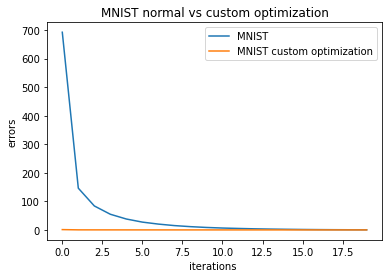

In [14]:
# Plot learning curve (with errors)

errors= np.squeeze(mce_mnist_train)
errors_opt = np.squeeze(mce_mnist_train_cust)
plt.plot(errors,label ='MNIST')
plt.plot(errors_opt,label ='MNIST custom optimization')
plt.ylabel('errors')
plt.xlabel('iterations ')
plt.title("MNIST normal vs custom optimization")
plt.legend()
plt.show()

## One Step Inference


In [ ]:
print("For MNIST inference\n")
#list to store inferences of test for 10 seeds
inference_mnist=[]

##accuracy
inference_mnist_acc=[]

Inferences_seeds=[5097,1111,1234,5678,199991,99999,3421,6642,8754,3454444]
NUM_EPOCHS=10
for seed in Inferences_seeds:
  print("For seed:{}\n".format(seed))
  mlp_on_gpu_cust = MLP_cust(size_input, size_hidden, size_output, device='gpu')
  time_start = time.time()
  mce_mnist_train_cust=[]

  #print("For MNIST  cust opt GPU\n")
  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    mlp_on_gpu_cust.initialize_custopt()
    lt = 0
    accuracy_train=0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(512)
    for inputs, outputs in train_ds:
      preds = mlp_on_gpu_cust.forward(inputs)
      loss_total_gpu = loss_total_gpu + mlp_on_gpu_cust.loss(preds, outputs)
      lt = lt + mlp_on_gpu_cust.loss(preds, outputs)
      mlp_on_gpu_cust.backward(inputs, outputs)
      #accuracy_train=tf.keras.metrics.CategoricalAccuracy()
      #accuracy_train.update_state(preds, outputs)
    mce_mnist_train_cust.append(np.sum(loss_total_gpu) / X_train.shape[0])
    # validation and accuracy calculation
    preds = mlp_on_gpu_cust.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    preds_val = mlp_on_gpu_cust.forward(X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    #print('Number of Epoch = {} - Average Cross Entropy:= {} - Validation Accuracy: {:.4f} - Train Accuracy: {:.4f} '.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0],cur_val_acc*100,ds*100))
  
  time_taken = time.time() - time_start
  #print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


  # Test DS for MNIST 
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)

  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(100)

  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = mlp_on_gpu.forward(inputs)
    test_loss_total = test_loss_total + mlp_on_gpu.loss(preds, outputs)

  # Test model
  preds_test = mlp_on_gpu.forward(X_test)
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  inference_mnist.append(np.sum(test_loss_total.numpy()) / X_test.shape[0])
  inference_mnist_acc.append(cur_test_acc)
  print('Test loss: {:.4f} - Test Accuracy:{:.2f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0],cur_test_acc))
  

For MNIST inference

For seed:5097



In [16]:
print("For MNIST custom inference\n")
#list to store inferences of test for 10 seeds
inference_mnist_cust=[]

##accuracy
inference_mnist_cust_acc=[]

Inferences_seeds=[5097,1111,1234,5678,199991,99999,3421,6642,8754,3454444]

for seed in Inferences_seeds:
  print("For seed:{}\n".format(seed))
  mlp_on_gpu_cust = MLP_cust(size_input, size_hidden, size_output, device='gpu')
  time_start = time.time()
  mce_mnist_train=[]

  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    mlp_on_gpu_cust.initialize_custopt()
    lt = 0
    accuracy_train=0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(512)
    for inputs, outputs in train_ds:
      preds = mlp_on_gpu_cust.forward(inputs)
      loss_total_gpu = loss_total_gpu + mlp_on_gpu_cust.loss(preds, outputs)
      lt = lt + mlp_on_gpu_cust.loss(preds, outputs)
      mlp_on_gpu_cust.backward(inputs, outputs)
    #accuracy_train=tf.keras.metrics.CategoricalAccuracy()
    #accuracy_train.update_state(preds, outputs)
    mce_mnist_train_cust.append(np.sum(loss_total_gpu) / X_train.shape[0])
    # validation and accuracy calculation
    preds = mlp_on_gpu_cust.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  preds_val = mlp_on_gpu_cust.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

    #print('Number of Epoch = {} - Average Cross Entropy:= {} - Validation Accuracy: {:.4f} - Train Accuracy: {:.4f} '.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0],cur_val_acc*100,ds*100))
  
  time_taken = time.time() - time_start
  #print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


  # Test DS for MNIST 
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)

  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(100)

  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = mlp_on_gpu_cust.forward(inputs)
    test_loss_total = test_loss_total + mlp_on_gpu_cust.loss(preds, outputs)

  # Test model
  preds_test = mlp_on_gpu_cust.forward(X_test)
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  inference_mnist_cust.append(np.sum(test_loss_total.numpy()) / X_test.shape[0])
  inference_mnist_cust_acc.append(cur_test_acc)
  print('Test loss: {:.4f} - Test Accuracy:{:.2f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0],cur_test_acc))
  

For MNIST custom inference

For seed:5097



IndexError: ignored

In [ ]:
# Plot learning curve (with errors)

errors= np.squeeze(inference_mnist)
errors_opt = np.squeeze(inference_mnist_cust)
plt.plot(errors,label ='Test MNIST')
plt.plot(errors_opt,label ='Test MNIST custom optimization')
plt.ylabel('errors')
plt.xlabel('iterations ')
plt.title("MNIST normal vs custom optimization")
plt.legend()
plt.show()